### <center> Creating Dense Neural Network to Identify the Stars that are, and are not, members of the M4 Globular Cluster </center>

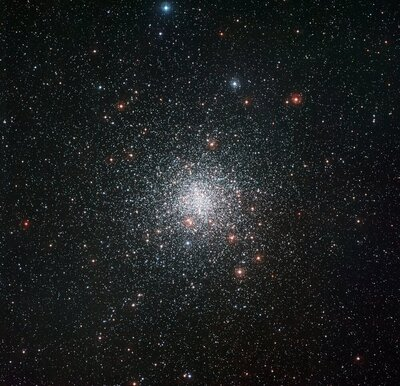

This notebook contains methods to build a dense neural network. Certain steps are transferable to other projects, but this one is designed specificially to classify the boundaries of the Messier 4 cluster.

This notebook uses two seperate sets of data on the cluster [one containing <em>only</em> cluster memebers, one containg cluster members and non members] to create training and testing sets, and will explore three training models, each using slightly different parameters.

The final products are three different training models, and an assesment of which one worked best. 

In [1]:
"""
All necessary imports.
"""

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from mpl_toolkits import mplot3d

!pip install --quiet tensorflow
import tensorflow as tf

In [2]:
"""
First, loading the dataset that includes only points [stars] loacted in the cluster.
"""
 
m4cluster_data = pd.read_fwf('NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4cluster_data

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


In [3]:
"""
Next, loading the dataset that includes all stars in and around the cluster.
"""

m4all_data = pd.read_csv('m4_gaia_source.txt')
m4all_data

,designation,source_id,ra,dec,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,...,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,dr2_radial_velocity,dr2_radial_velocity_error
0,Gaia EDR3 6045395206207939712,6045395206207939712,246.326865,-26.832059,2.281757,0.938617,2.430977,3.063687,-1.984960,0.992000,...,159.009460,20.188967,5.408175,21.200026,23.533007,18.994423,1.550609,2.205603,NaN,NaN
1,Gaia EDR3 6045395236261425664,6045395236261425664,246.304083,-26.848802,0.299751,0.144908,2.068563,5.767506,-4.697788,0.174918,...,743.382450,17.930620,54.349392,18.579592,131.545070,17.152450,1.260861,1.427141,NaN,NaN
2,Gaia EDR3 6045395236261439488,6045395236261439488,246.307110,-26.836059,0.706571,0.105734,6.682522,1.789414,-1.233496,0.128189,...,846.928340,17.423912,58.907173,18.303170,182.183960,16.493279,1.314571,1.809891,NaN,NaN
3,Gaia EDR3 6045395236261444096,6045395236261444096,246.303777,-26.833057,0.312718,0.152447,2.051325,4.602498,-1.532209,0.177778,...,706.781250,18.121668,58.547010,18.750223,101.846900,17.374300,1.244324,1.375923,NaN,NaN
4,Gaia EDR3 6045395236262412032,6045395236262412032,246.306579,-26.837706,-4.064154,1.596197,-2.546149,9.348937,-8.467994,1.399069,...,92.807950,20.524345,8.785514,20.602285,6.493096,19.284918,1.993188,1.317368,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494991,Gaia EDR3 6044393615532471040,6044393615532471040,247.494922,-27.292349,-0.367365,0.440535,-0.833908,1.647140,-0.303516,0.498371,...,217.021260,19.771519,15.770304,20.506021,19.696670,19.094887,1.153686,1.411135,NaN,NaN
494992,Gaia EDR3 6044393619826540160,6044393619826540160,247.499788,-27.295768,-1.205101,2.573437,-0.468285,0.243165,-0.227925,2.360466,...,96.446870,20.632820,4.934159,21.100240,11.897045,19.693460,1.471420,1.406780,NaN,NaN
494993,Gaia EDR3 6044393619826694656,6044393619826694656,247.498320,-27.288345,0.049188,1.874418,0.026242,7.034133,-3.381975,1.919752,...,91.789894,20.732970,4.707412,21.118761,7.163999,19.629623,1.671258,1.489138,NaN,NaN
494994,Gaia EDR3 6044393619827394944,6044393619827394944,247.497176,-27.288590,NaN,NaN,NaN,NaN,NaN,NaN,...,55.516743,20.853453,24.830143,20.959873,25.694584,19.802660,1.765481,1.157213,NaN,NaN


#### Getting familiar

First, we can plot the two datasets and get familiar with how they look, and especially how they overlap. Also being careful to get familiar with the difference in appearance of graphs of RA vs. Dec <em>[right ascention and declination]</em>, and pmRA vs. pmDec <em>[proper motion in RA, proper motion in Dec]</em>.

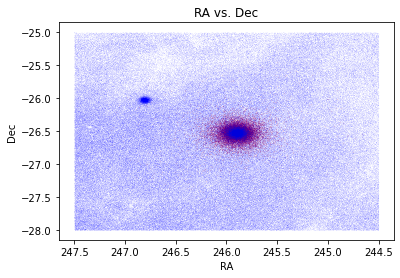

In [4]:
"""
Plotting both datasets to visualize what we are working with, and what we are trying to do.
"""

plt.scatter(m4cluster_data['ra'], m4cluster_data['dec'], s=0.001, c='r')
plt.scatter(m4all_data['ra'], m4all_data['dec'], s=0.0001, c='b')
plt.gca().invert_xaxis()
plt.ylabel('Dec');
plt.xlabel('RA');
plt.title('RA vs. Dec');

In [5]:
"""
How many of the points in our cluster specific dataset is in the general dataset? 
The cluster specific set contains 19508 points.
"""

m4_sel = m4all_data['source_id'].isin(m4cluster_data.source_id)
print(np.count_nonzero(m4_sel))

19084


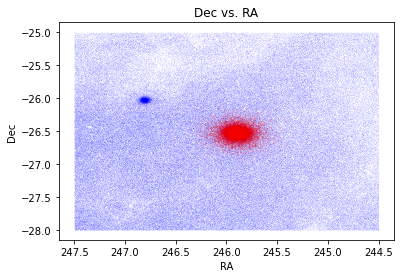

In [6]:
"""
How does the simple selection variable look? 
This will be a reference for our training models when using RA and DEC.
"""

plt.scatter(m4all_data.ra[~m4_sel], m4all_data.dec[~m4_sel], s=0.0001, c='b',label='all except for cluster')
plt.scatter(m4all_data.ra[m4_sel], m4all_data.dec[m4_sel], s=0.001, c='r', label='only cluster from all_data')
plt.gca().invert_xaxis()
plt.ylabel('Dec');
plt.xlabel('RA');
plt.title('Dec vs. RA');

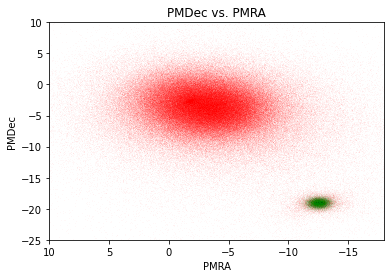

In [7]:
"""
We will later be looking at the difference in performance when using 
(RA, Dec) and (PMRA, PMDec).
"""

plt.scatter(m4all_data.pmra[~m4_sel], m4all_data.pmdec[~m4_sel], s=0.0001, c='r', label='not cluster')
plt.scatter(m4all_data.pmra[m4_sel], m4all_data.pmdec[m4_sel], s=0.0001, alpha=0.5, c='g', label='just lil guy')

plt.xlim([-18,10])
plt.ylim([-25,10])

plt.gca().invert_xaxis()
plt.xlabel('PMRA');
plt.ylabel('PMDec');
plt.title('PMDec vs. PMRA');

#### A: Setting up the first model with [RA, Dec]

In [8]:
"""
Step 1a

First task is to set up the input. Creating a 2D array of [RA, Dec] parameters, 
then pulling those parameters from from the larger dataset, and removing any points
with values missing for the parameters we are interested in. 

After that is set up, use StandarScaler().fit_transform to fit, transform, and standardize data X.
"""

#setting up desired parameters in a 2D array
parameters = ['ra', 'dec']
X = np.array(m4all_data[parameters])

#removing items with missing values
nan = np.any(np.isnan(X), axis=1)
X = X[~nan]

#standardizing
transform = StandardScaler()
X = transform.fit_transform(X)

In [9]:
"""
Step 2a

Next we need to create the testing and training data, as well as an output vector.

We will use test_sel to randomly divide the data X into testing and traing sets using np.random.choice.
By randomly selecting a bool for each point in X, and setting the percent of our data we wish to use for 
testing and training, we allocate 90% to training, and use the remaining 10% to test the results of 
the training. 
"""

#allocating testing data
m = X.shape[0]
print(m) 

#divider between test and training points
test_fraction = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_fraction, 1-test_fraction])

X_test = X[test_sel]
X_train = X[~test_sel]

#creating output vector
n_classes = 2
y = np.column_stack([~m4_sel, m4_sel]).astype(int)[~nan]
y, np.mean(y, axis=0)

y_test = y[test_sel]
y_train = y[~test_sel]

494996


In [10]:
"""
Step 3a

Now we can set up the model. First we set our Sequential() variable, which is specific 
to linear stacks, then add layers. #1 and #4 are required once each, #2/#3 
can be done anywhere from 1-n times, we will use only two here for ease. 

#1 - flattening the input shape?
#2, #3 - repeatable adding layers; dimensions of output space (10), 'relu' (rectified linear, used for
hidden layers)
#4 - activiation 'softmax' special for output layers
"""

dense_model = tf.keras.Sequential()

dense_model.add(layers.Flatten(input_shape=X.shape[1:])) #1
dense_model.add(layers.Dense(10, activation='relu')) #2
dense_model.add(layers.Dense(10, activation='relu')) #3
dense_model.add(layers.Dense(y.shape[1], activation='softmax')) #4

dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
"""
Establishing the testing/training outputs before running epochs.
"""

y_test = y[test_sel]
y_train = y[~test_sel]

In [12]:
"""
Important to check the model summary before running, to make sure everything looks ok.
Can see how many parameters span each layer.
Good to see that there are no non-trainable parameters (we ensured this in our variable construction).
"""

dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


In [13]:
"""
Step 4a

Run epochs! We have our X_train set being output to our y_train set, 
running 10 total tests, using our established test sets as validation.
"""

history = dense_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
13925/13925 [==============================] - 16s 1ms/step - loss: 0.0809 - accuracy: 0.9605 - val_loss: 0.0777 - val_accuracy: 0.9599
Epoch 2/10
13925/13925 [==============================] - 13s 951us/step - loss: 0.0765 - accuracy: 0.9609 - val_loss: 0.0775 - val_accuracy: 0.9601
Epoch 3/10
13925/13925 [==============================] - 14s 1ms/step - loss: 0.0764 - accuracy: 0.9610 - val_loss: 0.0776 - val_accuracy: 0.9622
Epoch 4/10
13925/13925 [==============================] - 17s 1ms/step - loss: 0.0763 - accuracy: 0.9609 - val_loss: 0.0775 - val_accuracy: 0.9622
Epoch 5/10
13925/13925 [==============================] - 18s 1ms/step - loss: 0.0762 - accuracy: 0.9611 - val_loss: 0.0773 - val_accuracy: 0.9622
Epoch 6/10
13925/13925 [==============================] - 15s 1ms/step - loss: 0.0762 - accuracy: 0.9611 - val_loss: 0.0772 - val_accuracy: 0.9622
Epoch 7/10
13925/13925 [==============================] - 13s 913us/step - loss: 0.0761 - accuracy: 0.9609 - val_los

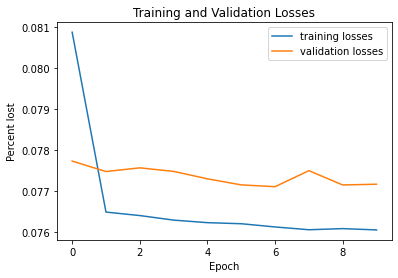

In [14]:
"""
Here is a quick plot to visual the information given with our epoch runs.
"""

plt.plot(history.history['loss'], label='training losses')
plt.plot(history.history['val_loss'], label='validation losses')
plt.legend()
plt.xlabel('Epoch');
plt.ylabel('Percent lost');
plt.title('Training and Validation Losses');

In [15]:
"""
Step 5a

Create a predicted out put based on our trained model, so we can plot and see how well it is doing.
"""

y_predict = dense_model.predict(X)

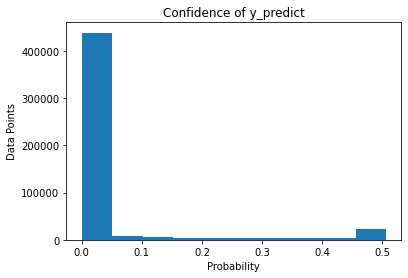

In [16]:
"""
Quick plot to show distribution of points between [1, None] or [0, None] of the output arrays, showing whether the 
point was read as in the cluster or not in.
"""

plt.hist(y_predict[:, 1]); #all rows, first column
plt.xlabel('Probability');
plt.ylabel('Data Points');
plt.title('Confidence of y_predict');

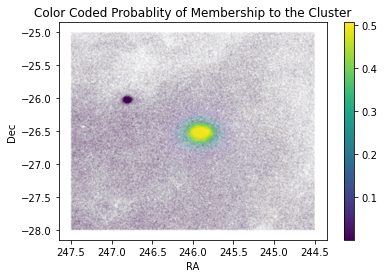

In [17]:
"""
Step 6a

Plotting the results of the model to see how it performed.
"""

plt.scatter(m4all_data.ra[~nan], m4all_data.dec[~nan], c=y_predict[:, 1], s=0.00005)
plt.colorbar()
plt.gca().invert_xaxis()
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Color Coded Probablity of Membership to the Cluster');

The model preformed well! It has accurately located the cluster, and the boundary seems to be precise. There is room for improvement in confidence, however, with max confidence of only 50%, even at the very center of the cluster.

#### B: Setting up the second model with [RA, Dec, Parallax]

In [18]:
"""
Step 1b

Repeating 1a with [RA, Dec, Parallax]
"""

#construct three parameters
parameters = ['ra', 'dec', 'parallax']
X = np.array(m4all_data[parameters])

#removing items with missing values
nan = np.any(np.isnan(X), axis=1)
X = X[~nan]

#standardize
transform = StandardScaler()
X = transform.fit_transform(X)

In [19]:
"""
Step 2b

Repeating step 2a. 
"""

#setting aside testing data
m = X.shape[0]
test_fraction = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_fraction, 1-test_fraction])

X_test = X[test_sel]
X_train = X[~test_sel]

#creating output vector
n_classes = 3
y = np.column_stack([~m4_sel, m4_sel]).astype(int)[~nan]
y, np.mean(y, axis=0)

y_test = y[test_sel]
y_train = y[~test_sel]

In [20]:
"""
Step 3b

Repeating 3a.
"""

dense_model = tf.keras.Sequential()

dense_model.add(layers.Flatten(input_shape=X.shape[1:]))
dense_model.add(layers.Dense(10, activation='relu'))
dense_model.add(layers.Dense(10, activation='relu'))
dense_model.add(layers.Dense(y.shape[1], activation='softmax'))

dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
"""
Important to check the model summary before running, to make sure everything looks ok.
Can see how many parameters span each layer.
Good to see that there are no non-trainable parameters (we ensured this in our variable construction).
"""

dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 10)                40        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________


In [22]:
"""
Step 4b

Run epochs! We have our X_train set being output to our y_train set, 
running 10 total tests, using our established test sets as validation.
"""

history = dense_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
11189/11189 [==============================] - 12s 1ms/step - loss: 0.0741 - accuracy: 0.9692 - val_loss: 0.0671 - val_accuracy: 0.9724
Epoch 2/10
11189/11189 [==============================] - 12s 1ms/step - loss: 0.0632 - accuracy: 0.9742 - val_loss: 0.0655 - val_accuracy: 0.9731
Epoch 3/10
11189/11189 [==============================] - 13s 1ms/step - loss: 0.0624 - accuracy: 0.9745 - val_loss: 0.0657 - val_accuracy: 0.9727
Epoch 4/10
11189/11189 [==============================] - 11s 969us/step - loss: 0.0622 - accuracy: 0.9745 - val_loss: 0.0652 - val_accuracy: 0.9730
Epoch 5/10
11189/11189 [==============================] - 11s 968us/step - loss: 0.0620 - accuracy: 0.9746 - val_loss: 0.0652 - val_accuracy: 0.9735
Epoch 6/10
11189/11189 [==============================] - 11s 976us/step - loss: 0.0619 - accuracy: 0.9745 - val_loss: 0.0646 - val_accuracy: 0.9735
Epoch 7/10
11189/11189 [==============================] - 11s 980us/step - loss: 0.0619 - accuracy: 0.9745 - val

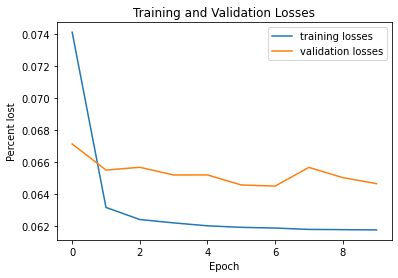

In [23]:
"""
Here is a quick plot to visual the information given with our epoch runs.
"""

plt.plot(history.history['loss'], label='training losses')
plt.plot(history.history['val_loss'], label='validation losses')
plt.legend()
plt.xlabel('Epoch');
plt.ylabel('Percent lost');
plt.title('Training and Validation Losses');

In [24]:
"""
Step 5b

Repeating 5a
"""

y_predict = dense_model.predict(X)

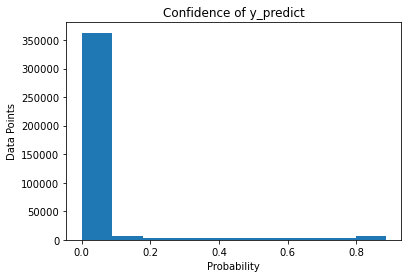

In [25]:
"""
Quick plot to show distribution of points between [1, None] or [0, None] of the output arrays, showing whether the 
point was read as in the cluster or not in.
"""

plt.hist(y_predict[:, 1]);
plt.xlabel('Probability');
plt.ylabel('Data Points');
plt.title('Confidence of y_predict');

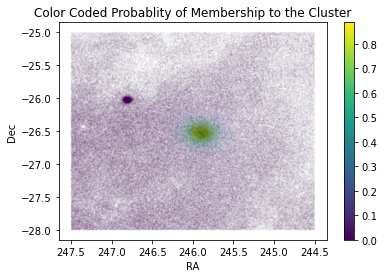

In [26]:
"""
Step 6b

Plotting the results of the model to see how it performed.
"""

plt.scatter(m4all_data.ra[~nan], m4all_data.dec[~nan], c=y_predict[:, 1], s=0.0001)
plt.colorbar()
plt.gca().invert_xaxis()
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Color Coded Probablity of Membership to the Cluster');

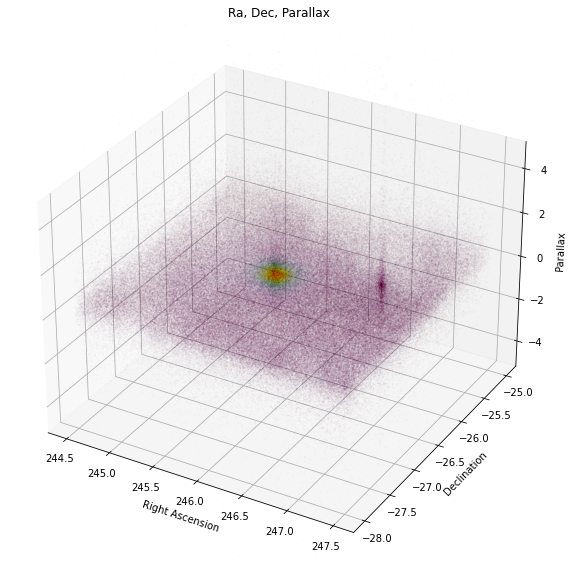

In [27]:
"""
Step 7b

Additional step here, because we used 3 parameters, we can create a 3D plot!
"""

x = m4all_data.ra[~nan]
y = m4all_data.dec[~nan]
z = m4all_data.parallax[~nan]

x_all = m4all_data['ra']
y_all = m4all_data['dec']
z_all = m4all_data['parallax']

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_zlim(-5, 5)

ax.scatter3D(x, y, z, s=0.0003, c=y_predict[:, 1])
ax.scatter3D(x_all, y_all, z_all, s=0.0003, c='r', alpha=0.1)
plt.title('Ra, Dec, Parallax')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_zlabel('Parallax')

plt.show()

This model, adding parallax to the parameters, preformed better than the first. It appears the cluster boundaries remained about the same, but that max certainty increased by 20-30% around the cluster center.

#### C: Setting up the third model with [pmRA, pmDec]

In [28]:
"""
Step 1c

Repeating 1a with [pmRA, pmDec]
"""

#setting two parameters
parameters = ['pmra', 'pmdec']
X = np.array(m4all_data[parameters])

#removing items with missing values
nan = np.any(np.isnan(X), axis=1)
X = X[~nan]

#standardize
transform = StandardScaler()
X = transform.fit_transform(X)

In [29]:
"""
Step 2c

Repeating step 2a. 
"""

#setting aside testing data
m = X.shape[0]
test_fraction = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_fraction, 1-test_fraction])
X_test = X[test_sel]
X_train = X[~test_sel]

#creating output vector
n_classes = 2
y = np.column_stack([~m4_sel, m4_sel]).astype(int)[~nan]
y, np.mean(y, axis=0)

y_test = y[test_sel]
y_train = y[~test_sel]

In [30]:
"""
Step 3c

Repeating 3a.
"""

dense_model = tf.keras.Sequential()

dense_model.add(layers.Flatten(input_shape=X.shape[1:]))
dense_model.add(layers.Dense(10, activation='relu'))
dense_model.add(layers.Dense(10, activation='relu'))
dense_model.add(layers.Dense(10, activation='relu'))
dense_model.add(layers.Dense(y.shape[1], activation='softmax'))

dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
"""
Important to check the model summary before running, to make sure everything looks ok.
Can see how many parameters span each layer.
Good to see that there are no non-trainable parameters (we ensured this in our variable construction).
"""

dense_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_6 (Dense)             (None, 10)                30        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 2)                 22        
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


In [32]:
"""
Step 4c

Run epochs! We have our X_train set being output to our y_train set, 
running 10 total tests, using our established test sets as validation.
"""

history = dense_model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
11195/11195 [==============================] - 15s 1ms/step - loss: 0.0457 - accuracy: 0.9807 - val_loss: 0.0362 - val_accuracy: 0.9838
Epoch 2/10
11195/11195 [==============================] - 12s 1ms/step - loss: 0.0368 - accuracy: 0.9838 - val_loss: 0.0337 - val_accuracy: 0.9854
Epoch 3/10
11195/11195 [==============================] - 12s 1ms/step - loss: 0.0361 - accuracy: 0.9843 - val_loss: 0.0340 - val_accuracy: 0.9850
Epoch 4/10
11195/11195 [==============================] - 12s 1ms/step - loss: 0.0358 - accuracy: 0.9844 - val_loss: 0.0339 - val_accuracy: 0.9850
Epoch 5/10
11195/11195 [==============================] - 12s 1ms/step - loss: 0.0357 - accuracy: 0.9844 - val_loss: 0.0343 - val_accuracy: 0.9854
Epoch 6/10
11195/11195 [==============================] - 12s 1ms/step - loss: 0.0355 - accuracy: 0.9846 - val_loss: 0.0335 - val_accuracy: 0.9855
Epoch 7/10
11195/11195 [==============================] - 12s 1ms/step - loss: 0.0356 - accuracy: 0.9845 - val_loss: 0

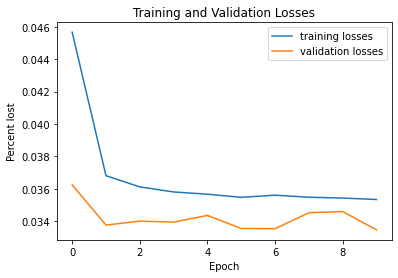

In [33]:
"""
Here is a quick plot to visual the information given with our epoch runs.
"""

plt.plot(history.history['loss'], label='training losses')
plt.plot(history.history['val_loss'], label='validation losses')
plt.legend()
plt.xlabel('Epoch');
plt.ylabel('Percent lost');
plt.title('Training and Validation Losses');

In [34]:
"""
Step 5c

Repeating 5a
"""

y_predict = dense_model.predict(X)

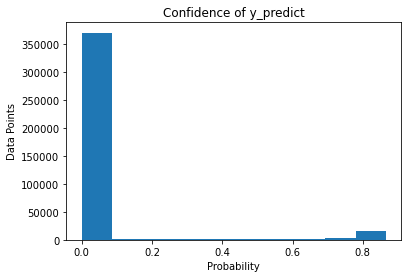

In [35]:
"""
Quick plot to show distribution of points between [1, None] or [0, None] of the output arrays, showing whether the 
point was read as in the cluster or not in.
"""

plt.hist(y_predict[:, 1]);
plt.xlabel('Probability');
plt.ylabel('Data Points');
plt.title('Confidence of y_predict');

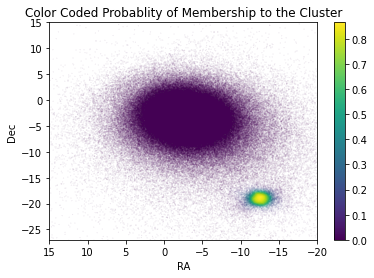

In [36]:
"""
Step 6c

Plotting the results of the model to see how it performed.
"""

plt.scatter(m4all_data.pmra[~nan], m4all_data.pmdec[~nan], c=y_predict[:, 1], s=0.001)
plt.colorbar()
plt.xlim([-20,15])
plt.ylim([-27,15])
plt.gca().invert_xaxis()
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Color Coded Probablity of Membership to the Cluster');

This model did best! We can see that the boundary of the cluster is pretty well defined, as well as much higher certainty than the first two models.

### Conclusion

This notebook has shown that the dense neural network created worked effectively. After creating it, and applying three different sets of parameters, we have seen it accurately, and with increasing confidence, classify a set of data. Its accuracy is dependent on the effectiveness of test variables chosen. 

To further test the models effectiveness, one could continue to adjust numbers of layers used, dimension of output space, number of epochs, training/testing distribution, batch size, and most fun- an entirely different set of data. 